<a href="https://colab.research.google.com/github/matthewpecsok/data_engineering/blob/main/tutorials/de_api_llm_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import userdata

# APIs and LLMs Tutorial

This notebook is intended to be used as a template notebook for the homework assingment on APIs and LLMs. You may use all of the code provided.

Make sure your runtime is set to a GPU or TPU!

Create a hugging face account. https://huggingface.co/

You'll need to accept the License Agreement first to get access to the model.

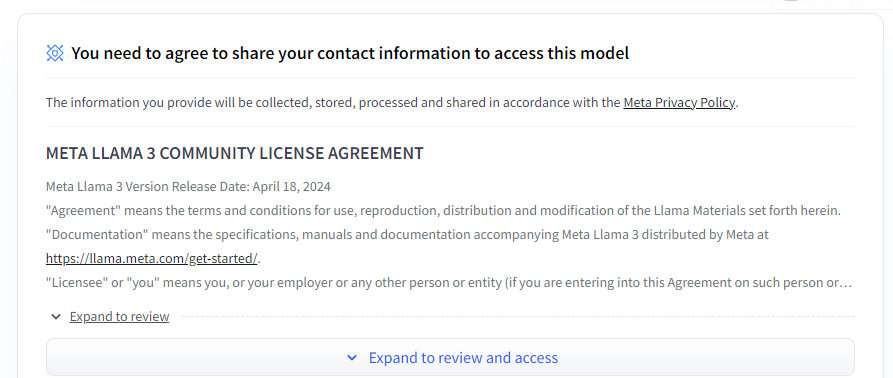

## Import the google places api token

In [50]:


gelato_reviews = [
   { "review_text": "The pistachio gelato was divine! It had the perfect balance of sweetness and nuttiness, with a creamy texture that melted in my mouth."},
    {"review_text": "I tried the stracciatella and salted caramel, they were heavenly. The chocolate chips were generously distributed throughout the creamy gelato, offering delightful bursts of chocolate in every spoonful."},
    {"review_text": "The mango gelato was incredibly refreshing. The vibrant flavor of ripe mango was perfectly captured, making it a perfect treat on a hot summer day."},
    {"review_text": "I wasn't a fan of the lemon gelato. It lacked the tanginess I was expecting and the texture was a bit icy."},
    {"review_text": "The hazelnut gelato was rich and decadent, with a pronounced hazelnut flavor. It was a bit too sweet for my liking, but still enjoyable."}
]


In [51]:
gelato_reviews

[{'review_text': 'The pistachio gelato was divine! It had the perfect balance of sweetness and nuttiness, with a creamy texture that melted in my mouth.'},
 {'review_text': 'I tried the stracciatella and salted caramel, they were heavenly. The chocolate chips were generously distributed throughout the creamy gelato, offering delightful bursts of chocolate in every spoonful.'},
 {'review_text': 'The mango gelato was incredibly refreshing. The vibrant flavor of ripe mango was perfectly captured, making it a perfect treat on a hot summer day.'},
 {'review_text': "I wasn't a fan of the lemon gelato. It lacked the tanginess I was expecting and the texture was a bit icy."},
 {'review_text': 'The hazelnut gelato was rich and decadent, with a pronounced hazelnut flavor. It was a bit too sweet for my liking, but still enjoyable.'}]

# Hugging Face Setups

This code will import the LLama model. It will take while. It's quite large.

We import the required packages, define the token variable and create a pipeline object. A pipeline defines what the model will do which model to use, what the token is and to use the GPU (device_map) if it's available.

In [23]:
import torch
from transformers import pipeline

HF_TOKEN = userdata.get('HF_TOKEN') # Your token must be in this secret.

pipe = pipeline("text-generation", "meta-llama/Meta-Llama-3-8B-Instruct", torch_dtype=torch.bfloat16, device_map="auto",token=HF_TOKEN)

model-00001-of-00004.safetensors:  11%|#         | 545M/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Device set to use cuda:0


## Process a single review

For now let's process just one review to get comfortable with the workflow

In [31]:
gelato_reviews

[{'revirew_text': 'The pistachio gelato was divine! It had the perfect balance of sweetness and nuttiness, with a creamy texture that melted in my mouth.'},
 {'revirew_text': 'I tried the stracciatella, and it was heavenly. The chocolate chips were generously distributed throughout the creamy gelato, offering delightful bursts of chocolate in every spoonful.'},
 {'revirew_text': 'The mango gelato was incredibly refreshing. The vibrant flavor of ripe mango was perfectly captured, making it a perfect treat on a hot summer day.'},
 {'revirew_text': "I wasn't a fan of the lemon gelato. It lacked the tanginess I was expecting and the texture was a bit icy."},
 {'revirew_text': 'The hazelnut gelato was rich and decadent, with a pronounced hazelnut flavor. It was a bit too sweet for my liking, but still enjoyable.'}]

## LLM chat setups

create a chat list defining what we want the LLM to accomplish, and what content to be used.

The dictionary with role = system defines the behavior we intend.
The dictionary with role = user is our review text to be evaluated.

In [34]:
chat = [
    {"role": "system", "content": "What specific flavors of gelato were mentioned? Return a list of strings with each flavor an element. If none were mentioned return a list with an element saying 'flavor-missing' only return the list. nothing else."},
    {"role": "user", "content": gelato_reviews[0]['review_text']}
]

chat

[{'role': 'system',
  'content': "What specific flavors of gelato were mentioned? Return a list of strings with each flavor an element. If none were mentioned return a list with an element saying 'flavor-missing' only return the list. nothing else."},
 {'role': 'user',
  'content': 'The pistachio gelato was divine! It had the perfect balance of sweetness and nuttiness, with a creamy texture that melted in my mouth.'}]

## Run the pipeline

This will return the generated text acting on the text provided.

The return is a STRING, but it looks like a list. We'll need to convert it.

In [35]:
chat_response = pipe(chat, max_new_tokens=512)
flavor_list_string = chat_response[0]['generated_text'][-1]['content']
print(flavor_list_string)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['pistachio']


In [ ]:
type(flavor_list_string)

We'll need a new package to convert the string into an actual python list object.

This package literally interprets the string. This literal interpretion results in a list object being created.

In [36]:
import ast
flavor_list = ast.literal_eval(flavor_list_string)

In [37]:
flavor_list

['pistachio']

In [38]:
type(flavor_list)

list

## Update the reviews with the chat response

put the list of flavors into the reviews dictionary

For the correct review, place the extract list of flavors mentioned into the review. We pulled the first review, so we can put the list into the first review.

In [40]:
gelato_reviews[0]['flavors'] = flavor_list

In [45]:
gelato_reviews[0]

{'review_text': 'The pistachio gelato was divine! It had the perfect balance of sweetness and nuttiness, with a creamy texture that melted in my mouth.',
 'flavors': ['pistachio']}

In [42]:
import pandas as pd

In [43]:
reviews_df = pd.DataFrame(gelato_reviews)
reviews_df

,review_text,flavors
0,The pistachio gelato was divine! It had the pe...,[pistachio]
1,"I tried the stracciatella, and it was heavenly...",NaN
2,The mango gelato was incredibly refreshing. Th...,NaN
3,I wasn't a fan of the lemon gelato. It lacked ...,NaN
4,"The hazelnut gelato was rich and decadent, wit...",NaN


In [52]:
for review in gelato_reviews:
  chat = [
    {"role": "system", "content": "What specific flavors of gelato were mentioned? Return a list of strings with each flavor an element. If none were mentioned return a list with an element saying 'flavor-missing' only return the list. nothing else."},
    {"role": "user", "content": review['review_text']}
]


  chat_response = pipe(chat, max_new_tokens=512)
  flavor_list_string = chat_response[0]['generated_text'][-1]['content']
  flavor_list = ast.literal_eval(flavor_list_string)
  review['flavors'] = flavor_list


gelato_reviews

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'review_text': 'The pistachio gelato was divine! It had the perfect balance of sweetness and nuttiness, with a creamy texture that melted in my mouth.',
  'flavors': ['pistachio']},
 {'review_text': 'I tried the stracciatella and salted caramel, they were heavenly. The chocolate chips were generously distributed throughout the creamy gelato, offering delightful bursts of chocolate in every spoonful.',
  'flavors': ['stracciatella', 'salted caramel']},
 {'review_text': 'The mango gelato was incredibly refreshing. The vibrant flavor of ripe mango was perfectly captured, making it a perfect treat on a hot summer day.',
  'flavors': ['mango']},
 {'review_text': "I wasn't a fan of the lemon gelato. It lacked the tanginess I was expecting and the texture was a bit icy.",
  'flavors': ['lemon']},
 {'review_text': 'The hazelnut gelato was rich and decadent, with a pronounced hazelnut flavor. It was a bit too sweet for my liking, but still enjoyable.',
  'flavors': ['hazelnut']}]